# House Prices Competition

This notebook shows my approach to Kaggle's 'House Prices Competition' giving result in top 7%

The steps in this notebook are:
- importing data
- dealing with missing data:
    - removing features with big procentage of missing data
    - imputing data (most common for categorical, mean for numerical)
- transforming categorical features into numerical
- exploring correlations and removing strongly correlated features
- fixing skewness of distribution of some features
- normalizing features
- splitting train-test data
- creating and fitting Ridge regression model on train data
- creating model on full train data and fitting on test data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
# import train data
df_train = pd.read_csv('train.csv', index_col='Id')
# get target values
y = df_train['SalePrice']
# get features data
df_train.drop(['SalePrice'], axis=1, inplace=True)
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [3]:
# import test data
df_test = pd.read_csv('test.csv')
# get id column
idx_col = df_test['Id']
# remove id column
df_test.drop(['Id'], axis=1, inplace=True)
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
print('size of train data: {}'.format(df_train.shape))
print('size of test data: {}'.format(df_test.shape))

size of train data: (1460, 79)
size of test data: (1459, 79)


- concatenate train and test features
    - this is done so that both train and test data can be transform at the same time, making sure they will get same numerical values for same input when transforming from categorical

In [5]:
df = pd.concat([df_train, df_test], axis=0)
df.reset_index(inplace=True, drop=True)

In [6]:
df.shape

(2919, 79)

## Missing data

In [7]:
# count missing values
df.isnull().sum().sum()

13965

\* in total 13965 missing values

In [8]:
# missing values for each feature in procentage
missing = df.isnull().sum()/df.shape[0]*100

- visualize procentage of missing data for each feature

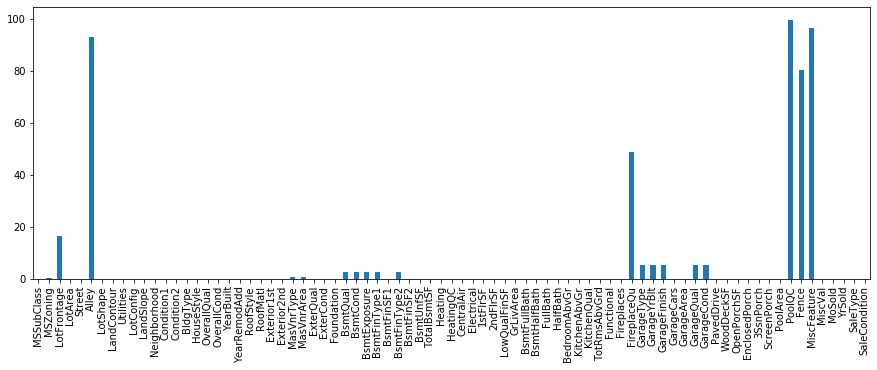

In [9]:
missing.plot.bar(figsize=(15,5))

In [10]:
# remove features that have more than 15% data missing
for column in df.columns:
    null_count = df[column].isnull().sum()
    if null_count/df.shape[0] > 0.15:
        df.drop([column], axis=1, inplace=True)

In [11]:
# count total number of missing values
df.isnull().sum().sum()

1267

\* total missing data reduced to 1267

In [12]:
df.shape

(2919, 73)

\* we are left with 73 features

#### Imput missing data and transform categorical data to numerical

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

In [14]:
# dtypes in our dataFrame
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [15]:
# Create pipelines

# pipeline for categorical features, 
# which impute missing values with most frequent in that feature and use labelEncoder to convert to numerical data
categorical_trans_label = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('transf', OrdinalEncoder())
])

# pipeline for numerical features, which imputes missing values with mean in that feature
numerical_trans = Pipeline([
    ('impute', SimpleImputer(strategy='mean'))
])

In [16]:
# create transform model
preprocess_pipeline = ColumnTransformer([
    ('numerical', numerical_trans, make_column_selector(dtype_exclude='O')),
    ('categorical', categorical_trans_label, make_column_selector(dtype_include='O'))
])

In [17]:
# transform data
transformed = preprocess_pipeline.fit_transform(df)

In [18]:
# add column names back
df_transformed = pd.DataFrame(transformed, columns=preprocess_pipeline.transformers_[0][2]+preprocess_pipeline.transformers_[1][2])
df_transformed.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,60.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,...,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1,20.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,...,4.0,3.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
2,60.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,...,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
3,70.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,...,4.0,2.0,6.0,5.0,2.0,4.0,4.0,2.0,8.0,0.0
4,60.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,...,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0


In [19]:
# count missing values
df_transformed.isnull().sum().sum()

0

## Correlations

In [20]:
# get train features and target
df_trans_train_y = df_transformed[df_transformed.index <= 1459]
df_trans_train_y['SalePrice'] = y.reset_index(drop=True)

C:\Users\Pawel\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
df_trans_train_y.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,60.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,...,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0,208500
1,20.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,...,3.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0,181500
2,60.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,...,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0,223500
3,70.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,...,2.0,6.0,5.0,2.0,4.0,4.0,2.0,8.0,0.0,140000
4,60.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,...,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0,250000


#### Plot correlation matrix

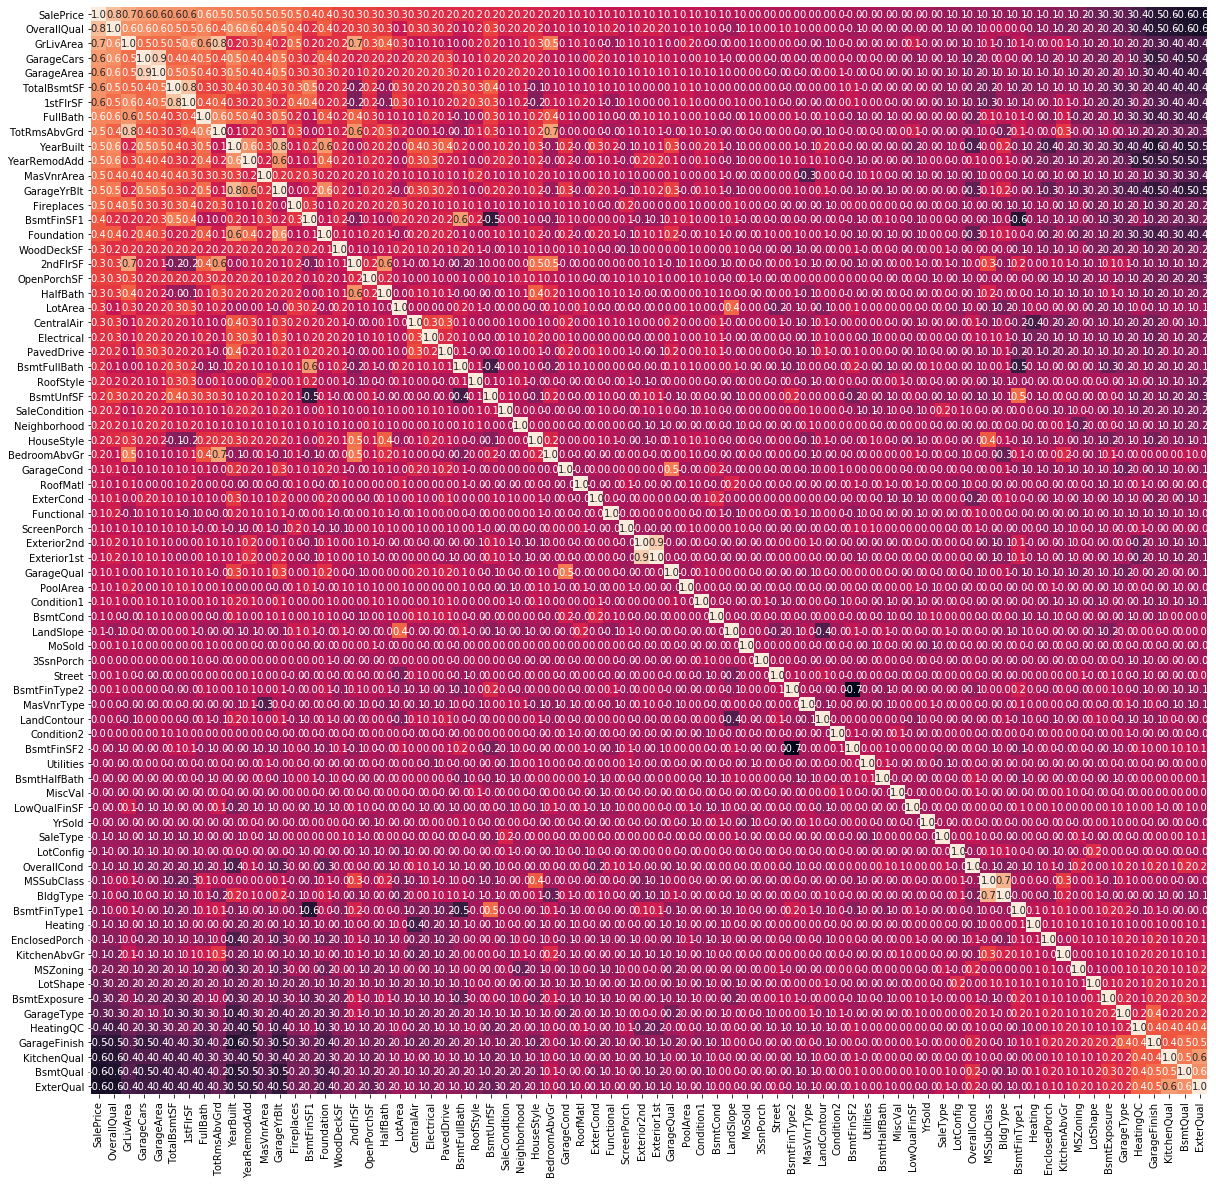

In [22]:
# create a heatmap showing correlations and sort it by correlation with SalePrice in descending order
correlation = df_trans_train_y.corr()
cols_all = correlation.nlargest(75, 'SalePrice')['SalePrice'].index
df_cor_all = np.corrcoef(df_trans_train_y[cols_all].values.T)

plt.figure(figsize=(20,20))
ax = sns.heatmap(df_cor_all, cbar=False, annot=True, fmt='.1f', yticklabels=cols_all.values, xticklabels=cols_all.values)
plt.show()

#### Remove features that are highly correlated / mean the same thing

In [23]:
# GarageCars and GarageArea 0.9 both indicate size of a garage
df_transformed.drop(['GarageCars'], axis=1, inplace=True)

# Exterior1st and Exterior2nd 0.9 are Exterior covering on house and second material if present
df_transformed.drop(['Exterior2nd'], axis=1, inplace=True)

# TotRmsAbvGrd and GrLivArea 0.8 both indicate size of the groud floor
df_transformed.drop(['TotRmsAbvGrd'], axis=1, inplace=True)

# GarageYrBlt and YearBuilt 0.8 assume that most garages were built together with the house
df_transformed.drop(['GarageYrBlt'], axis=1, inplace=True)

#TotalBsmtSF and 1stFlrSF 0.8
df_transformed.drop(['TotalBsmtSF'], axis=1, inplace=True)

In [24]:
df_transformed.shape

(2919, 68)

\* we are left with 68 features

## Distribution and skewness

In [25]:
from scipy import stats

#### Plot distribution and fixed skewness of some features

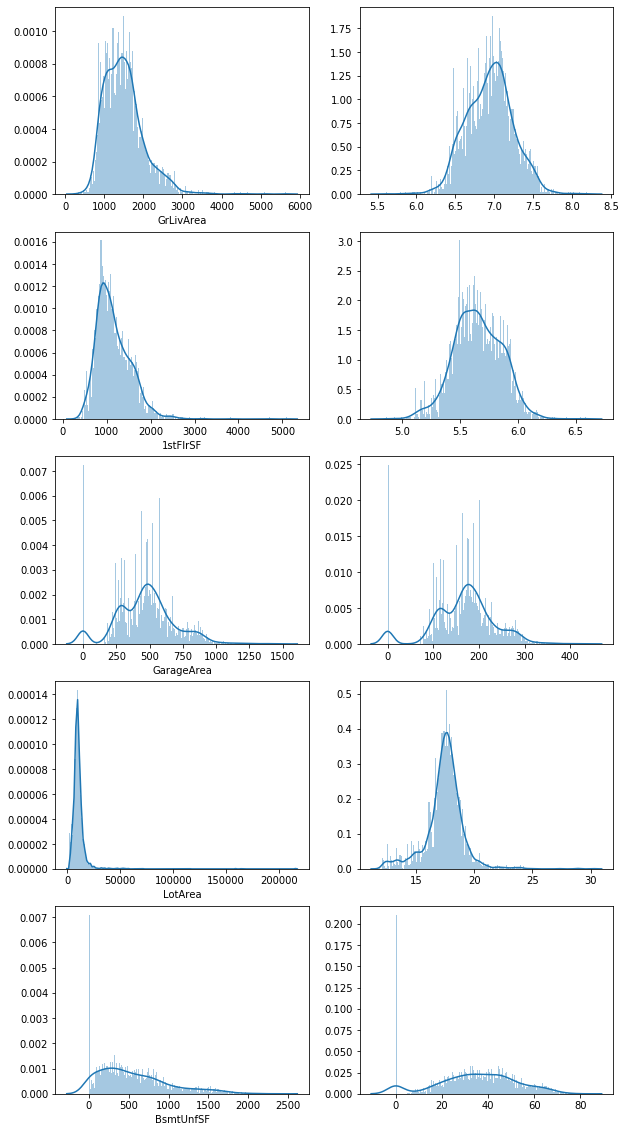

In [26]:
# show distribution of provided data (left) and after fixing skewness with Box-Cox transformation (right)
f,axes = plt.subplots(5,2, figsize=(10,20))

ax = sns.distplot(df_transformed['GrLivArea'], bins=200, ax=axes[0,0])
ax = sns.distplot(stats.boxcox(df_transformed['GrLivArea']+1)[0], bins=200, ax=axes[0,1])

ax = sns.distplot(df_transformed['1stFlrSF'], bins=200, ax=axes[1,0])
ax = sns.distplot(stats.boxcox(df_transformed['1stFlrSF']+1)[0], bins=200, ax=axes[1,1])

ax = sns.distplot(df_transformed['GarageArea'], bins=200, ax=axes[2,0])
ax = sns.distplot(stats.boxcox(df_transformed['GarageArea']+1)[0], bins=200, ax=axes[2,1])

ax = sns.distplot(df_transformed['LotArea'], bins=200, ax=axes[3,0])
ax = sns.distplot(stats.boxcox(df_transformed['LotArea']+1)[0], bins=200, ax=axes[3,1])

ax = sns.distplot(df_transformed['BsmtUnfSF'], bins=200, ax=axes[4,0])
ax = sns.distplot(stats.boxcox(df_transformed['BsmtUnfSF']+1)[0], bins=200, ax=axes[4,1])

#### remove skewness

In [27]:
# skewed columns
cols_rem_skew = ['GrLivArea', '1stFlrSF', 'GarageArea', 'LotArea', 'BsmtUnfSF']

In [28]:
# remove skewness using box-cox
for col in cols_rem_skew:
    df_transformed[col] = stats.boxcox(df_transformed[col]+1)[0]

## Normalize data

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed)

#### Separate transformed train and test datasets

In [31]:
# separate features to train and test sets
df_trans_train = df_transformed[df_transformed.index <= 1459]
df_trans_test = df_transformed[df_transformed.index > 1459]

## Split data

In [32]:
from sklearn.model_selection import train_test_split
from scipy.special import inv_boxcox

In [33]:
# split training data
X_train, X_test, y_train, y_test = train_test_split(df_trans_train, y, test_size=0.2, random_state=1)

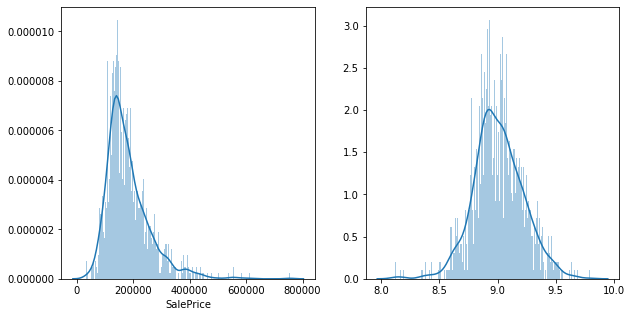

In [34]:
# show distribution and fixed skewness for target data
f,axes = plt.subplots(1,2, figsize=(10,5))

ax = sns.distplot(y_train, bins=200, ax=axes[0])
ax = sns.distplot(stats.boxcox(y_train+1)[0], bins=200, ax=axes[1])

In [35]:
# remove skewness in target
y_train_bc, lam = stats.boxcox(y_train)

## Ridge regression

In [38]:
from sklearn.linear_model import RidgeCV

# fit Ridge regression with cross validation to choose best alpha parameter preventing overfitting

clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]).fit(X_train, y_train_bc)

In [39]:
clf.score(X_train, y_train_bc)

0.8946886520372549

In [40]:
from sklearn.metrics import mean_absolute_error

In [42]:
# predict and evaluate target using splitted data and mean absolute error

clf_pred_train = inv_boxcox(clf.predict(X_train),lam)
clf_pred_test = inv_boxcox(clf.predict(X_test),lam)
clf_train_mae = mean_absolute_error(clf_pred_train, y_train)
print('train MAE: {}'.format(clf_train_mae))
clf_test_mae = mean_absolute_error(clf_pred_test, y_test)
print('test MAE: {}'.format(clf_test_mae))

train MAE: 15910.12097983445
test MAE: 16063.211842278128


In [43]:
# alpha in model that gave best results in RidgeCV
alpha = clf.alpha_

## Creating a Model For the Competition

In [44]:
from sklearn.linear_model import Ridge

- create model using entire train dataset

In [45]:
# removing skewness in target
y_bc, lam = stats.boxcox(y)

In [46]:
# To improve accuracy, create a new model which you will train on all training data
clf_on_full_data = Ridge(alpha=alpha)

# fit model on all data from the training data
clf_on_full_data.fit(df_trans_train,y_bc)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

- make predictions

In [48]:
# make predictions which will be submitted 
test_preds = inv_boxcox(clf_on_full_data.predict(df_trans_test),lam)

In [49]:
# save predictions in format used for competition scoring
output = pd.DataFrame({'Id': idx_col,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)